In [1]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

from scipy.stats import norm, gamma

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
import koopman_probabilistic
import model_objs

In [4]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [5]:
def MAE(x, x_hat):
    assert len(x) == len(x_hat)
    return np.sum(np.abs(x - x_hat)) / len(x)

In [6]:
def gaussian_quantiles(mu, sigma, quantiles):
    T = len(mu)
    assert(len(mu) == len(sigma))
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = norm(mu[t], sigma[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [7]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    assert(len(rate) == len(a))
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [8]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

# Gamma with time varying parameters

In [9]:
horizon = 400
horizons = [10, 50, 100, 400, 1_000, 10_000, 100_000]
train_through = 4000
t_vec = np.arange(train_through + horizons[-1])

periods = [96, 12]
a_vec = (np.exp(np.sin(2 * np.pi * t_vec / periods[0])) + np.cos(2 * np.pi * t_vec / periods[1])) ** 2 + 4
scale_vec = 0.5 * np.sin(2 * np.pi * t_vec / periods[1]) + np.cos(2 * np.pi * t_vec / periods[0]) + 2
x2 = np.random.gamma(a_vec, scale=scale_vec).reshape(-1, 1)

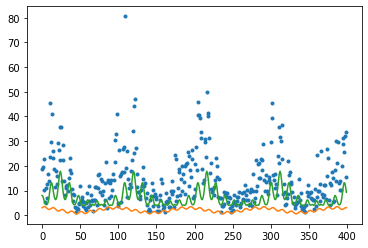

In [10]:
idx = 400
plt.plot(x2[:idx], ".")
plt.plot(scale_vec[:idx])
plt.plot(a_vec[:idx])

## Darts forecast

In [11]:
from darts.utils.likelihood_models import GammaLikelihood, GaussianLikelihood

In [12]:
df = pd.DataFrame({"t_vec": pd.to_datetime(t_vec, unit="D"), "x_vec": x2[:, 0]})

from darts import TimeSeries

# Create a TimeSeries, specifying the time and value columns
series2 = TimeSeries.from_dataframe(df, 't_vec', 'x_vec')[:train_through]

[2022-01-08 18:48:03,330] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-01-08 18:48:03,330] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
[2022-01-08 18:48:03,841] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3413 samples.
[2022-01-08 18:48:03,841] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3413 samples.
[2022-01-08 18:48:03,955] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 18:48:03,955] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


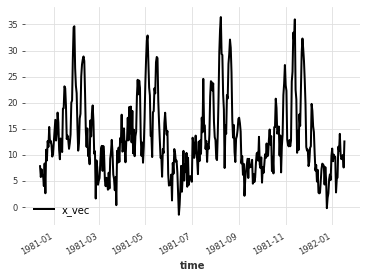

In [13]:
from darts.models import NBEATSModel

nbmodel2 = NBEATSModel(input_chunk_length=188, output_chunk_length=horizon)
nbmodel2.fit(series2)
prednb2 = nbmodel2.predict(horizon)

prednb2.plot()

[2022-01-08 19:34:26,141] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 19:34:26,141] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 19:34:26,150] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 19:34:26,150] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


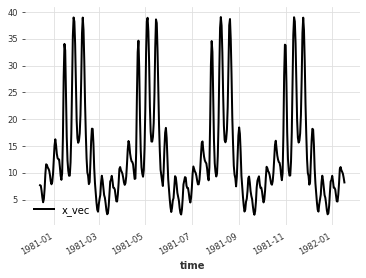

In [14]:
from darts.models import RNNModel

modlstm2 = RNNModel(model="LSTM", input_chunk_length=188, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200)
modlstm2.fit(series2)
predlstm2 = modlstm2.predict(horizon)

predlstm2.plot()

[2022-01-08 19:54:58,735] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 19:54:58,735] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 19:54:58,743] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 19:54:58,743] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


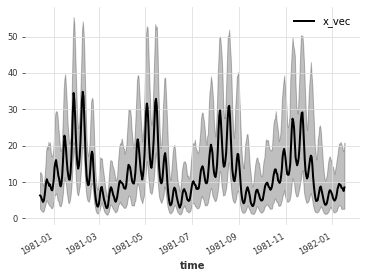

In [15]:
from darts.models import RNNModel  # probabilistic

modlstm2gamma = RNNModel(model="LSTM", input_chunk_length=188, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200, likelihood=GammaLikelihood())
modlstm2gamma.fit(series2)
predlstm2gamma = modlstm2gamma.predict(horizon, num_samples=1000)

predlstm2gamma.plot()

[2022-01-08 20:16:00,437] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2022-01-08 20:16:00,437] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2022-01-08 20:16:00,442] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-01-08 20:16:00,442] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-01-08 20:16:00,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 20:16:00,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


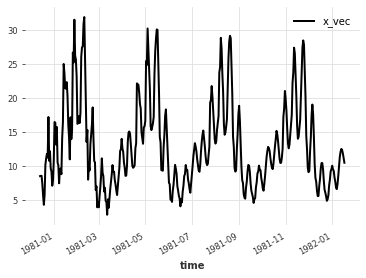

In [16]:
from darts.models import TCNModel

modeltcn2 = TCNModel(input_chunk_length=188, output_chunk_length=96)
modeltcn2.fit(series2)
predtcn2 = modeltcn2.predict(horizon)

predtcn2.plot()

[2022-01-08 20:22:06,054] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2022-01-08 20:22:06,054] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2022-01-08 20:22:06,058] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-01-08 20:22:06,058] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-01-08 20:22:06,058] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 20:22:06,058] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


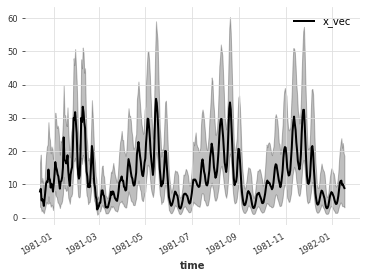

In [17]:
#probabilistic
from darts.models import TCNModel

modeltcn2gamma = TCNModel(input_chunk_length=188, output_chunk_length=96, dropout=0, kernel_size=3, num_filters=3, likelihood=GammaLikelihood())
modeltcn2gamma.fit(series2)
predtcn2gamma = modeltcn2gamma.predict(horizon, num_samples=1000)

predtcn2gamma.plot()

In [18]:
num_freqs = [2, 2]
num_fourier = 2
model2 = model_objs.GammaNLL(x_dim=x2.shape[1], num_freqs=num_freqs, n=256)
k2 = koopman_probabilistic.KoopmanProb(model2, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
k2.find_fourier_omegas(x2[:train_through], hard_code=periods)

fourier periods: tensor([96.0000, 12.0000], dtype=torch.float64)


tensor([0.0654, 0.5236], dtype=torch.float64)

In [19]:
k2.fit(x2[:train_through], iterations=8000, verbose=True, interval=20, cutoff=0, weight_decay=1e-7, lr_theta=1e-4, lr_omega=0, training_mask=None);

Iteration  0
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  14.679113
Iteration  1
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  10.178085
Iteration  2
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  8.143587
Iteration  3
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  6.9673066
Iteration  4
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  6.1938095
Iteration  5
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  5.640827
Iteration  6
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  5.2224216
Iteration  7
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 1

In [20]:
predict_through = train_through + horizon
params2 = k2.predict(predict_through)
rate_hat, a_hat = params2
scale_hat = 1 / rate_hat
path = "./darts_comparisons/synthGamma1"
np.save(path + "_rate.py", rate_hat)
np.save(path + "_a.py", a_hat)

In [21]:
mean_hat2 = model2.mean(params2)
std_hat2 = model2.std(params2)

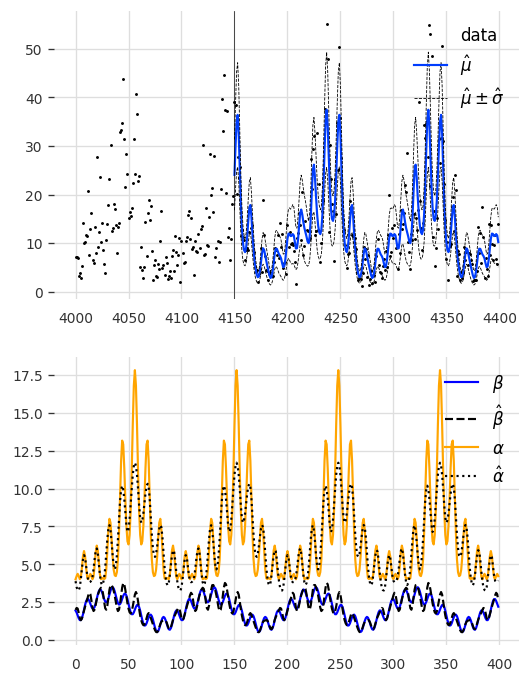

In [22]:
%matplotlib inline
plt.subplots(figsize=(5, 7), dpi=120)
idx = 150 + train_through
plt.subplot(211)
pt = np.arange(predict_through)
plt.plot(pt[train_through:], x2[train_through:predict_through], ".", markersize=1.5, label="data")
# colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
# for j in range(0, len(quantiles), 1):
#     plt.plot(pt[idx:], quant_preds[idx:, j], color=colors[j], linewidth=0.5, label=quantiles[j])
plt.plot(pt[idx:], mean_hat2[idx:], label="$\hat \mu$")
plt.plot(pt[idx:], mean_hat2[idx:] + std_hat2[idx:], "--k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
plt.plot(pt[idx:], mean_hat2[idx:] - std_hat2[idx:], "--k", linewidth=0.5)
plt.axvline(idx, color="k", linewidth=0.4)
plt.legend(loc="upper right", framealpha=1)
plt.subplot(212)
plt.plot(scale_vec[train_through:predict_through], "b", label="$\\beta$")
plt.plot(scale_hat[train_through:], "--k", label="$\hat \\beta$")
plt.plot(a_vec[train_through:predict_through], "orange", label="$\\alpha$")
plt.plot(a_hat[train_through:], ":k", label="$\hat \\alpha$")
plt.legend(loc="upper right", framealpha=1)

In [23]:
print("DPK:", MAE(x2[train_through:train_through + horizon], mean_hat2[train_through:]))
print("NBEATS:", MAE(x2[train_through:train_through + horizon], prednb2.values()))
print("LSTM:", MAE(x2[train_through:train_through + horizon], predlstm2.values()))
print("TCN:", MAE(x2[train_through:train_through + horizon], predtcn2.values()))

DPK: 3.9083024643917894
NBEATS: 4.259985969952002
LSTM: 4.101231609489875
TCN: 4.33205775755927


In [24]:
num_quants = 9
quantiles = np.arange(1, num_quants + 1, dtype=np.float32) / (num_quants + 1)
predlstm2quantiles = predlstm2gamma.quantiles_df(quantiles)
predtcn2quantiles = predtcn2gamma.quantiles_df(quantiles)

In [25]:
predlstm2quantiles = np.array([[float(predlstm2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])
predtcn2quantiles = np.array([[float(predtcn2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])

In [26]:
# path = "./darts_comparisons/synthGamma1"
# rate_hat = np.load(path + "_rate.py.npy")
# a_hat = np.load(path + "_a.py.npy")

In [27]:
quant_preds2 = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

In [28]:
print("DPK:", pinball_loss(x2[train_through:train_through + horizon], quant_preds2[train_through:], quantiles))
print("LSTM:", pinball_loss(x2[train_through:train_through + horizon], predlstm2quantiles, quantiles))
print("TCN:", pinball_loss(x2[train_through:train_through + horizon], predtcn2quantiles, quantiles))

DPK: [1.50674436]
LSTM: [1.70244779]
TCN: [1.64478012]


In [30]:
pinballs2 = {"DPK": [], "LSTM": [], "TCN": []}
MAEs2 = {"DPK": [], "LSTM": [], "TCN": [], "NBEATS": []}

for h in horizons[:-1]:
    
    print(h)
    print("# dpk")
    predict_through = train_through + h
    _params2 = k2.predict(predict_through)
    _rate_hat, _a_hat = _params2
    _scale_hat = 1 / _rate_hat
    path = "./darts_comparisons/synthGamma1_" + str(h)
    np.save(path + "_rate.py", _rate_hat)
    np.save(path + "_a.py", _a_hat)
    _mean_hat2 = model2.mean(_params2)
    _std_hat2 = model2.std(_params2)
    _quant_preds2 = gamma_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
    pinballs2["DPK"].append(pinball_loss(x2[train_through:train_through + h], _quant_preds2[train_through:], quantiles))
    MAEs2["DPK"].append(MAE(x2[train_through:train_through + h], _mean_hat2[train_through:]))

    print("# lstm gamma")
    _predlstm2gamma = modlstm2gamma.predict(h, num_samples=1000)
    _predlstm2quantiles = _predlstm2gamma.quantiles_df(quantiles)
    _predlstm2quantiles = np.array([[float(_predlstm2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs2["LSTM"].append(pinball_loss(x2[train_through:train_through + h], _predlstm2quantiles, quantiles))

    # lstm
    _predlstm2 = modlstm2.predict(h)
    MAEs2["LSTM"].append(MAE(x2[train_through:train_through + h], _predlstm2.values()))

    if h != 10000:
        print("# tcn gamma")
        _predtcn2gamma = modeltcn2gamma.predict(h, num_samples=1000)
        _predtcn2quantiles = _predtcn2gamma.quantiles_df(quantiles)
        _predtcn2quantiles = np.array([[float(_predtcn2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
        pinballs2["TCN"].append(pinball_loss(x2[train_through:train_through + h], _predtcn2quantiles, quantiles))

    # tcn
    _predtcn2 = modeltcn2.predict(h)
    MAEs2["TCN"].append(MAE(x2[train_through:train_through + h], _predtcn2.values()))

    # nbeats -- this is not how N-BEATs is meant to be used since it is designed to be trained for a specific forecast horizon
    _prednb2 = nbmodel2.predict(h)
    MAEs2["NBEATS"].append(MAE(x2[train_through:train_through + h], _prednb2.values()))


# additionally run DPK for an even longer forecast
h = horizons[-1]
print(h)
print("# dpk")
predict_through = train_through + h
_params2 = k2.predict(predict_through)
_rate_hat, _a_hat = _params2
_scale_hat = 1 / _rate_hat
path = "./darts_comparisons/synthGamma1_" + str(h)
np.save(path + "_rate.py", _rate_hat)
np.save(path + "_a.py", _a_hat)
_mean_hat2 = model2.mean(_params2)
_std_hat2 = model2.std(_params2)
_quant_preds2 = gamma_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
pinballs2["DPK"].append(pinball_loss(x2[train_through:train_through + h], _quant_preds2[train_through:], quantiles))
MAEs2["DPK"].append(MAE(x2[train_through:train_through + h], _mean_hat2[train_through:]))


10
# dpk
# lstm gamma
# tcn gamma
50
# dpk
# lstm gamma
# tcn gamma
100
# dpk
# lstm gamma
# tcn gamma
400
# dpk
# lstm gamma
# tcn gamma
1000
# dpk
# lstm gamma
# tcn gamma
10000
# dpk
# lstm gamma
100000
# dpk


In [31]:
pinballs2

{'DPK': [array([0.68101165]),
  array([1.4605063]),
  array([1.26419975]),
  array([1.50674436]),
  array([1.55274794]),
  array([1.55650611]),
  array([1.54772258])],
 'LSTM': [array([0.64828699]),
  array([1.51164903]),
  array([1.35825714]),
  array([1.69004901]),
  array([2.05218732]),
  array([2.76883136])],
 'TCN': [array([0.70864932]),
  array([1.6714979]),
  array([1.47931043]),
  array([1.6461762]),
  array([1.70054703])]}

In [32]:
MAEs2

{'DPK': [1.6159362093706293,
  3.7545401271412295,
  3.1960808460519843,
  3.9083024643917894,
  4.035318694399472,
  4.044480699959955,
  4.016660888916245],
 'LSTM': [1.5113588397869888,
  4.18789108788074,
  3.5449162574645112,
  4.101231609489875,
  5.054019922540398,
  9.44325963184477],
 'TCN': [1.9068303795136572,
  4.626358852019316,
  3.77667106651918,
  4.33205775755927,
  4.747705897759936,
  6.618652092148503],
 'NBEATS': [2.5268516781976773,
  3.872795125041565,
  3.7061078219258756,
  4.259985969952002,
  5.886483975748218,
  4.830355361878454]}

# Gaussian with time-varying mean and variance

In [33]:
t_vec = np.arange(4000 + horizons[-1])
mu_vec = 2 * np.sin(1 + np.sin(2 * np.pi * t_vec / 48))
sigma_vec = np.exp(np.sin(2 * np.pi * t_vec / 31) - 1) + 0.5
x = np.random.normal(mu_vec, sigma_vec).reshape(-1, 1)

## Darts forecast

In [34]:
df = pd.DataFrame({"t_vec": pd.to_datetime(t_vec, unit="D"), "x_vec": x[:, 0]})

from darts import TimeSeries

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 't_vec', 'x_vec')[:train_through]

[2022-01-08 22:24:24,343] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 22:24:24,343] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 22:24:24,349] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 22:24:24,349] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


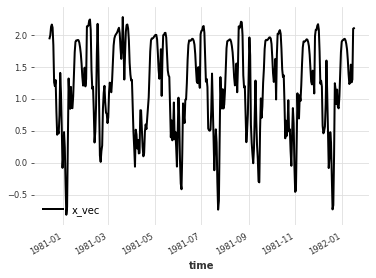

In [35]:
from darts.models import RNNModel

mod = RNNModel(model="LSTM", input_chunk_length=96, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200)
mod.fit(series)
predlstm = mod.predict(horizon)

predlstm.plot()

[2022-01-08 22:45:42,326] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 22:45:42,326] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2022-01-08 22:45:42,332] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 22:45:42,332] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


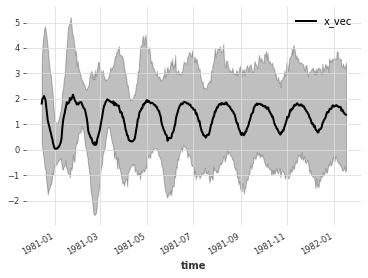

In [36]:
from darts.models import RNNModel  # probabilistic

modlstmGaussian = RNNModel(model="LSTM", input_chunk_length=96, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200, likelihood=GaussianLikelihood())
modlstmGaussian.fit(series)
predlstmGaussian = modlstmGaussian.predict(horizon, num_samples=1000)

predlstmGaussian.plot()

[2022-01-08 23:07:13,792] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3505 samples.
[2022-01-08 23:07:13,792] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3505 samples.
[2022-01-08 23:07:13,864] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 23:07:13,864] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


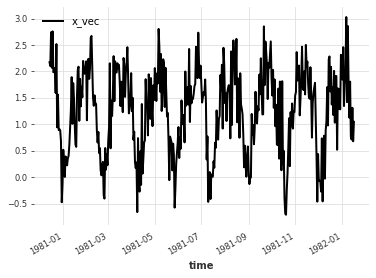

In [37]:
from darts.models import NBEATSModel

modnb = NBEATSModel(input_chunk_length=96, output_chunk_length=horizon)
modnb.fit(series)
prednb = modnb.predict(horizon)

prednb.plot()

[2022-01-08 23:54:21,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2022-01-08 23:54:21,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2022-01-08 23:54:21,439] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 23:54:21,439] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 23:54:21,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 23:54:21,450] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


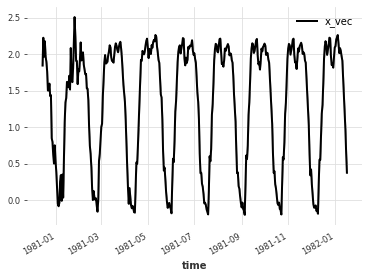

In [38]:
#deterministic
from darts.models import TCNModel

modtcn = TCNModel(input_chunk_length=96, output_chunk_length=48, dropout=0, kernel_size=3, num_filters=3)
modtcn.fit(series)
predtcn= modtcn.predict(horizon, num_samples=1000)

predtcn.plot()

[2022-01-08 23:58:18,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2022-01-08 23:58:18,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2022-01-08 23:58:18,670] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 23:58:18,670] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 23:58:18,672] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 23:58:18,672] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


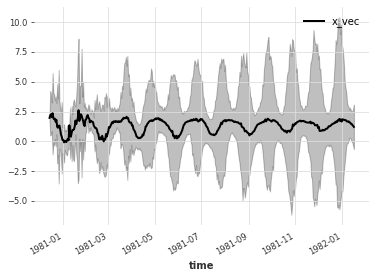

In [39]:
#probabilistic

modtcnGaussian = TCNModel(input_chunk_length=96, output_chunk_length=48, dropout=0, kernel_size=3, num_filters=3, likelihood=GaussianLikelihood())
modtcnGaussian.fit(series)
predtcnGaussian= modtcnGaussian.predict(horizon, num_samples=1000)

predtcnGaussian.plot()

In [40]:
num_freqs = [2, 2]
num_fourier = 2
model = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=num_freqs, n=256)
k = koopman_probabilistic.KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
k.find_fourier_omegas(x[:train_through], hard_code=[48, 31])

fourier periods: tensor([48.0000, 31.0000], dtype=torch.float64)


tensor([0.1309, 0.2027], dtype=torch.float64)

In [41]:
k.fit(x[:train_through], iterations=8000, verbose=True, interval=20, cutoff=0, weight_decay=1e-7, lr_theta=1e-4, lr_omega=0, training_mask=None);

Iteration  0
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.952705907139221
Iteration  1
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.9173837267645788
Iteration  2
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.8817275385042236
Iteration  3
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.8456914251369003
Iteration  4
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.8092339817660628
Iteration  5
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackwar

In [42]:
predict_through = train_through + horizon
params = k.predict(predict_through)
mu_hat, sigma_hat = params

In [43]:
path = "./darts_comparisons/synthGaussian1"
np.save(path + "_mu.py", mu_hat)
np.save(path + "_sigma.py", sigma_hat)

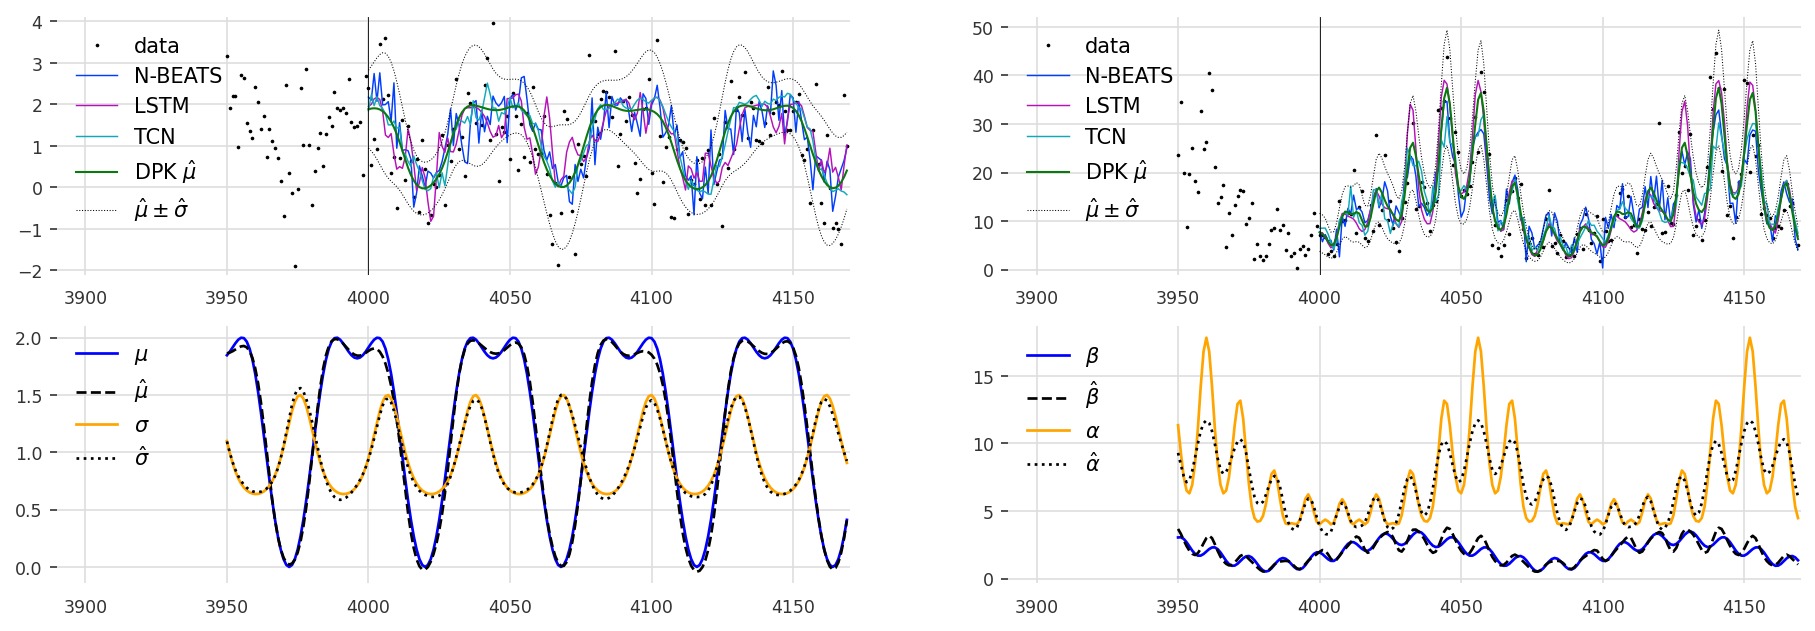

In [44]:
predict_through = train_through + horizon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), dpi=150)
idx = 50
end_offset = 180
start = train_through - idx
end = predict_through - idx - end_offset
pt = np.arange(predict_through)
axs[0, 0].plot(pt[start:end], x[start:end], ".", label="data", markersize=1.5)
axs[0, 0].plot(pt[train_through:end], prednb[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="N-BEATS")
axs[0, 0].plot(pt[train_through:end], predlstm[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="LSTM")
axs[0, 0].plot(pt[train_through:end], predtcn[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="TCN")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end], linewidth=1, label="DPK $\hat \mu$")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end] + sigma_hat[train_through:end], ":k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end] - sigma_hat[train_through:end], ":k", linewidth=0.5)
axs[0, 0].axvline(train_through, color="k", linewidth=0.4)
axs[0, 0].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[0, 0].set_ylim([-2.1, 4.1])
axs[0, 0].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
axs[1, 0].plot(pt[start:end], mu_vec[start:end], "b", label="$\mu$")
axs[1, 0].plot(pt[start:end], mu_hat[start:end], "--k", label="$\hat \mu$")
axs[1, 0].plot(pt[start:end], sigma_vec[start:end], "orange", label="$\sigma$")
axs[1, 0].plot(pt[start:end], sigma_hat[start:end], ":k", label="$\hat \sigma$")
axs[1, 0].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[1, 0].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)

axs[0, 1].plot(pt[start:end], x2[start:end], ".", label="data", markersize=1.5)
axs[0, 1].plot(pt[train_through:end], prednb2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="N-BEATS")
axs[0, 1].plot(pt[train_through:end], predlstm2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="LSTM")
axs[0, 1].plot(pt[train_through:end], predtcn2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="TCN")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end], linewidth=1, label="DPK $\hat \mu$")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end] + std_hat2[train_through:end], ":k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end] - std_hat2[train_through:end], ":k", linewidth=0.5)
axs[0, 1].axvline(train_through, color="k", linewidth=0.4)
axs[0, 1].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[0, 1].set_ylim([-1, 52])
axs[0, 1].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
axs[1, 1].plot(pt[start:end], scale_vec[start:end], "b", label="$\\beta$")
axs[1, 1].plot(pt[start:end], scale_hat[start:end], "--k", label="$\hat \\beta$")
axs[1, 1].plot(pt[start:end], a_vec[start:end], "orange", label="$\\alpha$")
axs[1, 1].plot(pt[start:end], a_hat[start:end], ":k", label="$\hat \\alpha$")
axs[1, 1].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[1, 1].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
plt.show()


In [45]:
print("DPK:", MAE(x[train_through:train_through + horizon], mu_hat[train_through:]))
print("NBEATS:", MAE(x[train_through:train_through + horizon], prednb.values()))
print("TCN:", MAE(x[train_through:train_through + horizon], predtcn.values()))
print("LSTM:", MAE(x[train_through:train_through + horizon], predlstm.values()))

DPK: 0.7574855674475282
NBEATS: 0.8596570170919645
TCN: 0.7802527931560397
LSTM: 0.9639545291175403


In [46]:
num_quants = 9
quantiles = np.arange(1, num_quants + 1, dtype=np.float32) / (num_quants + 1)
predlstmquantiles = predlstmGaussian.quantiles_df(quantiles)
predtcnquantiles = predtcnGaussian.quantiles_df(quantiles)

predlstmquantiles = np.array([[float(predlstmquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])
predtcnquantiles = np.array([[float(predtcnquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])

path = "./darts_comparisons/synthGaussian1"
mu_hat = np.load(path + "_mu.py.npy")
sigma_hat = np.load(path + "_sigma.py.npy")

quant_preds = gaussian_quantiles(mu_hat, sigma_hat, quantiles=quantiles)

print("DPK:", pinball_loss(x[train_through:train_through + horizon], quant_preds[train_through:], quantiles))
print("LSTM:", pinball_loss(x[train_through:train_through + horizon], predlstmquantiles, quantiles))
print("TCN:", pinball_loss(x[train_through:train_through + horizon], predtcnquantiles, quantiles))

DPK: [0.29392706]
LSTM: [0.31986336]
TCN: [0.32416468]


In [47]:
pinballs = {"DPK": [], "LSTM": [], "TCN": []}
MAEs = {"DPK": [], "LSTM": [], "TCN": [], "NBEATS": []}

In [48]:
for h in horizons[:-1]:
    
    print(h)
    print("# dpk")
    predict_through = train_through + h
    _params = k.predict(predict_through)
    _rate_hat, _a_hat = _params
    _scale_hat = 1 / _rate_hat
    path = "./darts_comparisons/synthGaussian1_" + str(h)
    np.save(path + "_rate.py", _rate_hat)
    np.save(path + "_a.py", _a_hat)
    _mean_hat = model.mean(_params)
    _std_hat = model.std(_params)
    _quant_preds = gaussian_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
    pinballs["DPK"].append(pinball_loss(x[train_through:train_through + h], _quant_preds[train_through:], quantiles))
    MAEs["DPK"].append(MAE(x[train_through:train_through + h], _mean_hat[train_through:]))

    print("# lstm gamma")
    _predlstmGaussian = modlstmGaussian.predict(h, num_samples=1000)
    _predlstmquantiles = _predlstmGaussian.quantiles_df(quantiles)
    _predlstmquantiles = np.array([[float(_predlstmquantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs["LSTM"].append(pinball_loss(x[train_through:train_through + h], _predlstmquantiles, quantiles))

    # lstm
    _predlstm = mod.predict(h)
    MAEs["LSTM"].append(MAE(x[train_through:train_through + h], _predlstm.values()))

    print("# tcn gamma")
    _predtcnGaussian = modtcnGaussian.predict(h, num_samples=1000)
    _predtcnquantiles = _predtcnGaussian.quantiles_df(quantiles)
    _predtcnquantiles = np.array([[float(_predtcnquantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs["TCN"].append(pinball_loss(x[train_through:train_through + h], _predtcnquantiles, quantiles))

    # tcn
    _predtcn = modtcn.predict(h)
    MAEs["TCN"].append(MAE(x[train_through:train_through + h], _predtcn.values()))

    # nbeats WARNING this is not how N-BEATs is meant to be used since it must be trained for a specific forecast horizon--only read h=horizon
    _prednb = modnb.predict(h)
    MAEs["NBEATS"].append(MAE(x[train_through:train_through + h], _prednb.values()))

# additionally run DPK for an even longer forecast
h = horizons[-1]
print(h)
print("# dpk")
predict_through = train_through + h
_params = k.predict(predict_through)
_rate_hat, _a_hat = _params
_scale_hat = 1 / _rate_hat
path = "./darts_comparisons/synthGaussian1_" + str(h)
np.save(path + "_rate.py", _rate_hat)
np.save(path + "_a.py", _a_hat)
_mean_hat = model.mean(_params)
_std_hat = model.std(_params)
_quant_preds = gaussian_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
pinballs["DPK"].append(pinball_loss(x[train_through:train_through + h], _quant_preds[train_through:], quantiles))
MAEs["DPK"].append(MAE(x[train_through:train_through + h], _mean_hat[train_through:]))

    

10
# dpk
# lstm gamma
# tcn gamma
50
# dpk
# lstm gamma
# tcn gamma
100
# dpk
# lstm gamma
# tcn gamma
400
# dpk
# lstm gamma
# tcn gamma
1000
# dpk
# lstm gamma
# tcn gamma
10000
# dpk
# lstm gamma
# tcn gamma
100000
# dpk


In [49]:
pinballs

{'DPK': [array([0.34369531]),
  array([0.28837543]),
  array([0.28810691]),
  array([0.29392706]),
  array([0.28979622]),
  array([0.29679732]),
  array([0.29871533])],
 'LSTM': [array([0.3517048]),
  array([0.28962426]),
  array([0.29285058]),
  array([0.31822518]),
  array([0.35169446]),
  array([0.37856937])],
 'TCN': [array([0.37590107]),
  array([0.31232759]),
  array([0.30421486]),
  array([0.32366309]),
  array([0.38649416]),
  array([0.47723196])]}

In [50]:
MAEs

{'DPK': [0.9723892428021687,
  0.7581670306873126,
  0.7349349305038984,
  0.7574855674475282,
  0.7491110620057772,
  0.7693762184176072,
  0.7721177997515181],
 'LSTM': [1.0073483122087943,
  0.7401832095039541,
  0.8017907076338837,
  0.9639545291175403,
  1.1808391870154715,
  1.1498084584880361],
 'TCN': [1.0539628434170227,
  0.7864059158622949,
  0.76649360207801,
  0.7802527931560397,
  0.7651249603937604,
  0.9605223936581444],
 'NBEATS': [1.0097810855046183,
  0.8492050103027659,
  0.8587162292971706,
  0.8596570170919645,
  0.9273659947352555,
  0.8250715618221635]}

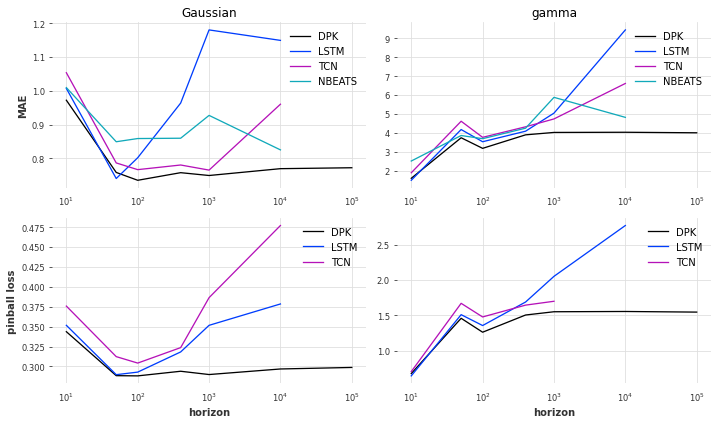

In [51]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title("Gaussian")
for p in MAEs:
    plt.plot(horizons[:len(MAEs[p])], MAEs[p], label=p)
plt.ylabel("MAE")
plt.semilogx()
plt.legend()

plt.subplot(222)
plt.title("gamma")
for p in MAEs:
    plt.plot(horizons[:len(MAEs2[p])], MAEs2[p], label=p)
plt.semilogx()
plt.legend()

plt.subplot(223)
for p in pinballs:
    plt.plot(horizons[:len(pinballs[p])], pinballs[p], label=p)
plt.ylabel("pinball loss")
plt.xlabel("horizon")
plt.semilogx()
plt.legend()

plt.subplot(224)
for p in pinballs2:
    plt.plot(horizons[:len(pinballs2[p])], pinballs2[p], label=p)
plt.xlabel("horizon")
plt.semilogx()
plt.legend()

plt.tight_layout()
plt.show()

# 3D plot

In [52]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\ATMal\AppData\Local\Temp/ipykernel_9648/994065295.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


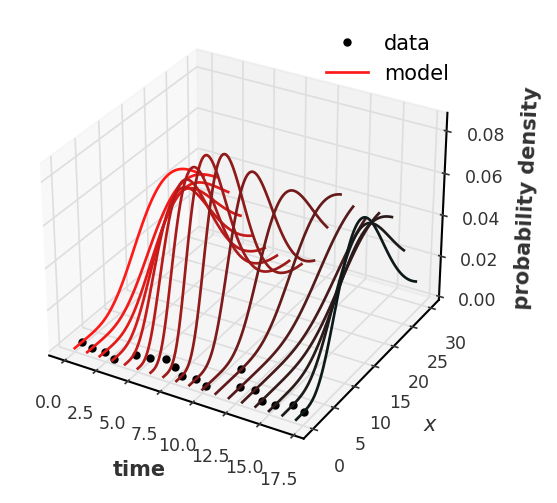

In [53]:
# (t, x, pdf)
start = 0
end = 18
step = 1
ts = np.arange(start, end, step)
xs = x[ts]
pdfs = []
fig = plt.figure(dpi=150)
ax = fig.gca(projection='3d')
ax.plot(ts, xs, np.zeros(len(xs)), ".")
for t in ts:
    lins = np.linspace(0, 30, 100)
    pdf = gamma.pdf(lins, a_hat[t], scale=scale_hat[t])
    pdfs.append(pdf)
    ax.plot(t * np.ones(len(lins)), lins, pdf, color=(((end - t) / (end - start)), 0.1, 0.1))
plt.xlabel("time")
plt.ylabel("$x$")
ax.set_zlabel("probability density")
plt.legend(["data", "model"])